In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import *
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import warnings

In [2]:
# Disable Warnings
warnings.filterwarnings('ignore')

In [3]:
# Load CSV file
reviews = pd.read_csv('data/YoutubeCommentsDataSet.csv', sep=',')

In [4]:
reviews.rename(columns={'Comment' : 'comment', 'Sentiment' : 'sentiment'}, inplace=True)

In [5]:
reviews['comment']

0        lets not forget that apple pay in 2014 require...
1        here in nz 50 of retailers don’t even have con...
2        i will forever acknowledge this channel with t...
3        whenever i go to a place that doesn’t take app...
4        apple pay is so convenient secure and easy to ...
                               ...                        
18403    i really like the point about engineering tool...
18404    i’ve just started exploring this field and thi...
18405    excelente video con una pregunta filosófica pr...
18406    hey daniel just discovered your channel a coup...
18407    this is great focus is key a playful approach ...
Name: comment, Length: 18408, dtype: object

In [6]:
reviews['sentiment']

0         neutral
1        negative
2        positive
3        negative
4        positive
           ...   
18403    positive
18404    positive
18405     neutral
18406    positive
18407    positive
Name: sentiment, Length: 18408, dtype: object

In [7]:
# Remove nulls from dataframe
reviews.dropna(inplace=True)

In [8]:
reviews['comment_length'] = reviews['comment'].str.len()

In [9]:
reviews['comment_length']

0        317
1        163
2        183
3        450
4        135
        ... 
18403    277
18404    118
18405    244
18406     88
18407    404
Name: comment_length, Length: 18364, dtype: int64

(0.0, 1000.0)

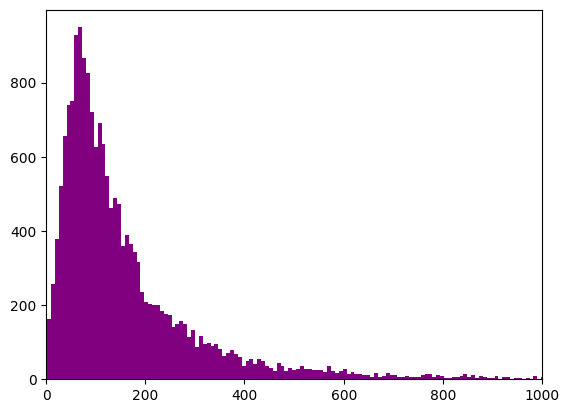

In [10]:
plt.hist(reviews['comment_length'], bins=1000, color='purple')
plt.xlim(0, 1000)

In [11]:
max(reviews['comment_length'])

7847

In [12]:
np.mean(reviews['comment_length'])

np.float64(177.5541276410368)

In [13]:
np.median(reviews['comment_length'])

np.float64(113.0)

In [14]:
# Remove duplicate rows
reviews = reviews[~reviews.duplicated()]
reviews

,comment,sentiment,comment_length
0,lets not forget that apple pay in 2014 require...,neutral,317
1,here in nz 50 of retailers don’t even have con...,negative,163
2,i will forever acknowledge this channel with t...,positive,183
3,whenever i go to a place that doesn’t take app...,negative,450
4,apple pay is so convenient secure and easy to ...,positive,135
...,...,...,...
18403,i really like the point about engineering tool...,positive,277
18404,i’ve just started exploring this field and thi...,positive,118
18405,excelente video con una pregunta filosófica pr...,neutral,244
18406,hey daniel just discovered your channel a coup...,positive,88


In [15]:
# Confirm duplicate rows have been removed
len(reviews[reviews.duplicated()])

0

In [16]:
# Set all reviews to lowercase to maintain consistency
reviews['comment'] = reviews['comment'].str.lower()

In [17]:
# Remove non-ASCII characters
reviews['comment'] = reviews['comment'].str.replace(r'[^\x00-\x7F]+', '', regex=True)

In [18]:
# Remove punctuation and numbers
reviews['comment'] = reviews['comment'].apply(lambda x : re.sub(r'[^A-Za-z\s]', '', x))

In [19]:
# Verify that unnecessary values were removed
mask = reviews['comment'].str.contains(r'[^A-Za-z ]', regex=True, na=False)
print(reviews[mask])

Empty DataFrame
Columns: [comment, sentiment, comment_length]
Index: []


In [20]:
# Remove extra spaces
reviews['comment'] = reviews['comment'].str.split().str.join(' ')

In [21]:
# Remove leading and trailing whitespace
reviews['comment'] = reviews['comment'].str.strip()

In [22]:
# Confirm there are no extra spaces (i.e., no more than 2 spaces together
mask = reviews['comment'].str.contains(r'\s{2,}', regex=True, na=False)
print(reviews[mask])

Empty DataFrame
Columns: [comment, sentiment, comment_length]
Index: []


In [23]:
# Get rid of stopwords and perform stemming
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
def preprocess(text):
    tokens = text.split()
    processed = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(processed)

reviews['comment'] = reviews['comment'].apply(preprocess)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
reviews['comment'].head(10)

0    let forget appl pay requir brand new iphon ord...
1    nz retail dont even contactless credit card ma...
2    forev acknowledg channel help lesson idea expl...
3    whenev go place doesnt take appl pay doesnt ha...
4    appl pay conveni secur easi use use korean jap...
5    weve hound bank adopt appl pay understand dont...
6                got appl pay south africa wide accept
7                     need appl pay physic credit card
8    unit state abund retail accept appl pay still ...
9    cambodia univers qr code system scan send mone...
Name: comment, dtype: object

In [25]:
# Tokenize comments
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=6000, oov_token="<OOV>")
X = reviews['comment']
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

Median: 12.0
90th percentile: 35.0


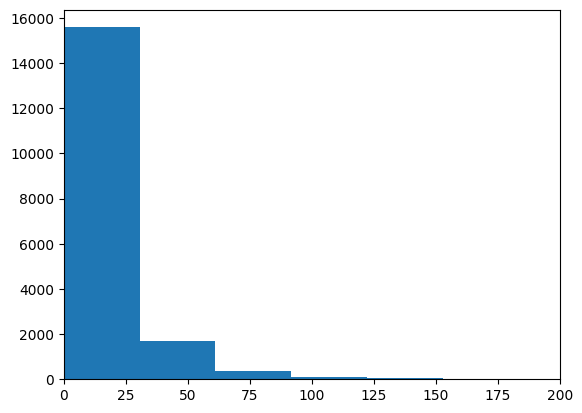

In [26]:
# Compute lengths of each sublist
lengths = [len(sublist) for sublist in X]

import statistics

plt.hist(lengths, bins=30)
plt.xlim(0, 200)

median_length = statistics.median(lengths)
print(f'Median: {median_length}')
print(f'90th percentile: {np.percentile(lengths, 90)}')

In [27]:
reviews['comment_lengths'] = reviews['comment'].str.split().apply(len)

(0.0, 200.0)

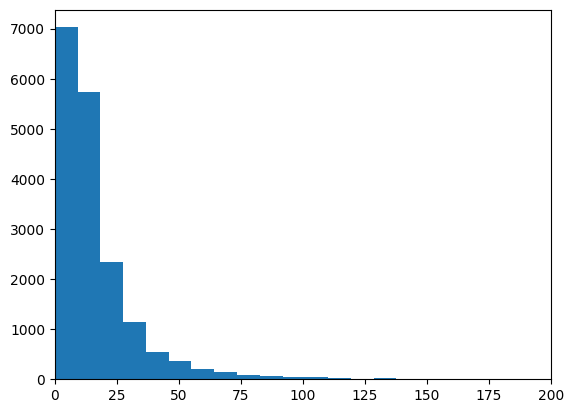

In [28]:
plt.hist(reviews['comment_lengths'], bins = 100)
plt.xlim(0, 200)

In [29]:
np.median(reviews['comment_lengths'])

np.float64(12.0)

In [30]:
# maxlen = max(len(seq) for seq in X) + 1
maxlen = int(np.percentile(lengths, 90))
X = pad_sequences(X, maxlen=maxlen, padding='post', truncating='post')
y = reviews['sentiment']

In [31]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(reviews['sentiment'])
y

array([1, 0, 2, ..., 1, 2, 2], shape=(17874,))

In [32]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y)
y

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], shape=(17874, 3))

In [33]:
X

array([[  97,  631,  160, ...,  816,    0,    0],
       [   1, 1824,   27, ...,    0,    0,    0],
       [ 796, 2495,   85, ...,    0,    0,    0],
       ...,
       [2139,    2,  662, ...,    1,  310,  330],
       [ 359, 2935,  967, ...,    0,    0,    0],
       [  12,  637,  881, ...,  408, 1536,  293]],
      shape=(17874, 35), dtype=int32)

In [34]:
# Split data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

In [35]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval() 
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted_classes = torch.max(outputs, 1)
            all_predictions.extend(predicted_classes.cpu().numpy())
            all_labels.extend(labels.squeeze().cpu().numpy())
            
    avg_loss = total_loss / len(data_loader.dataset)
    true_labels = np.array(all_labels)
    predicted_labels = np.array(all_predictions)
    accuracy = accuracy_score(true_labels, predicted_labels)
    model.train() 
    return avg_loss, accuracy

In [58]:
import torch
import torch.nn as nn

VOCAB_SIZE = 10000
EMBED_SIZE = 128
LSTM_UNITS = 128
BATCH_SIZE = 128
N_EPOCHS = 15 

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_units):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(
            input_size=embed_size,
            hidden_size=lstm_units,
            batch_first=True
        )
        self.dropout = nn.Dropout(0.3)
        self.dense = nn.Linear(lstm_units,3)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        final_state = h_n.squeeze(0)
        x = self.dropout(final_state)
        
        return self.dense(x)

model = SentimentModel(VOCAB_SIZE, EMBED_SIZE, LSTM_UNITS)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Model Architecture:\n", model)

Model Architecture:
 SentimentModel(
  (embedding): Embedding(10000, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (dense): Linear(in_features=128, out_features=3, bias=True)
)


In [59]:
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long).squeeze()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {
            'sequence': self.sequences[idx],
            'label': self.labels[idx]
        }
        return sample

In [60]:
from torch.utils.data import DataLoader

train_data = SentimentDataset(X_train, y_train)
val_data = SentimentDataset(X_test, y_test)
train_loader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0 
)
val_loader = DataLoader(
    dataset=val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0 
)

In [61]:
from sklearn.metrics import accuracy_score
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, device):
    model.to(device)

    best_val_loss = float('inf')
    patience = 2
    trigger_times = 0
    
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        
        for i, batch in enumerate(train_loader):
            inputs = batch['sequence'].to(device)
            labels = batch['label'].to(device) 
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), 'best_model.pt')  # save best model
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        print(f'Epoch {epoch+1}/{n_epochs}')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')

train_model(model, train_loader, val_loader, criterion, optimizer, N_EPOCHS, device)

Epoch 1/15
Train Loss: 0.9142
Validation Loss: 0.9022
Epoch 2/15
Train Loss: 0.8982
Validation Loss: 0.8939
Epoch 3/15
Train Loss: 0.8026
Validation Loss: 0.7368
Epoch 4/15
Train Loss: 0.6675
Validation Loss: 0.6745
Epoch 5/15
Train Loss: 0.5773
Validation Loss: 0.6388
Epoch 6/15
Train Loss: 0.5002
Validation Loss: 0.6519
Early stopping at epoch 7
